# DSLWP-B Doppler analysis

In this notebook we perform and analyse orbit determination of DSLWP-B using S-band Doppler measurments by Scott Tilley VE7TIL and GMAT.

In [1]:
%matplotlib inline

Set this to the path of your GMAT installation:

In [2]:
GMAT_PATH = '/home/daniel/GMAT/R2018a/'

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import subprocess

# Larger figure size
fig_size = [10, 6]
plt.rcParams['figure.figsize'] = fig_size

Below we set the published frequency of the S-band beacon of DSLWP-B. There is an offset in the Doppler measurements by VE7TIL that we must correct. Probably, this Doppler is due to the beacon not been perfectly in frequency.

In [4]:
freq = 2275222e3
c = 299792458 # speed of light
f_shift = -3400 # Shift to apply to VE7TIL Doppler measurement

Utility functions to load reports from GMAT and write Doppler information in the format expected by GMAT.

In [5]:
def load_report(path):
    ncols = 14
    data = np.fromfile(path, sep=' ')
    return data.reshape((data.size // ncols, ncols))

def load_ve7til_doppler(path):
    ncols = 4
    leap_seconds = 37 # for UTC to TAI conversion
    data = np.fromfile(path, sep=' ')
    data = data.reshape((data.size // ncols, ncols))[:,:2]
    data[:,0] += leap_seconds/(24*3600) - 29999.5
    s = np.argsort(data[:,0])
    data = data[s,:]
    return data

def load_rangerate(path):
    with open(path) as f:
        return np.array([(l.split()[0], l.split()[7]) for l in f.readlines()[2:]], dtype='float')

def write_doppler_gmd(data, path):
    doppler_interval = 10
    with open(path, 'w') as f:
        for j in range(data.shape[0]):
            line = '{} RangeRate 9012 VE7TIL DSLWP-B 1 {} {}\n'.format(data[j,0] + 0.5*doppler_interval/(24*3600), doppler_interval, -2*(data[j,1]-freq+f_shift)*1e-3*c/freq)
            f.write(line)

Position of each field in the GMAT report.

In [6]:
utc = 0
tai = 1
dslwp_x = 2
dslwp_v = 5
luna_x = 8
luna_v = 11

Load report file as computed by GMAT (note that the GMAT script `dslwp_doppler.script` must have been run before this in simulation mode to generate Doppler data). The report contains the position and velocity of DSLWP-B and the Moon in VE7TIL's frame of reference. This can be used to compute Doppler, disregarding the finite speed of light and the Doppler measurement interval.

In [7]:
report = load_report('VE7TIL.txt')

Load Doppler data by VE7TIL, select some points to exclude because they do not give a good match, and write the Doppler information in GMAT's format.

In [8]:
doppler = load_ve7til_doppler('ve7til_doppler/all.dat')
exclude = ((doppler[:,0] > 28268.5) & (doppler[:,0] < 28269.2)) | ((doppler[:,0] > 28266.75) & (doppler[:,0] < 28267.5)) \
    | ((doppler[:,0] > 28272.5) & (doppler[:,0] < 28273.6))
write_doppler_gmd(doppler[~exclude,:], '/tmp/VE7TIL.gmd')

Load simulated RangeRate information from GMAT (note that the GMAT script `dslwp_doppler.script` must have been run before this in estimation mode). Compute Doppler using the data from GMAT report.

In [9]:
gmat_doppler = load_rangerate(GMAT_PATH + 'output/DSLWP_Doppler.gmd')

dslwp_rangerate = np.sum(report[:,dslwp_v:dslwp_v+3] * report[:,dslwp_x:dslwp_x+3], axis=1) / np.sqrt(np.sum(report[:,dslwp_x:dslwp_x+3]**2, axis=1))
luna_rangerate = np.sum(report[:,luna_v:luna_v+3] * report[:,luna_x:luna_x+3], axis=1) / np.sqrt(np.sum(report[:,luna_x:luna_x+3]**2, axis=1))

## Plot Doppler simulation from GMAT and VE7TIL's measurements.

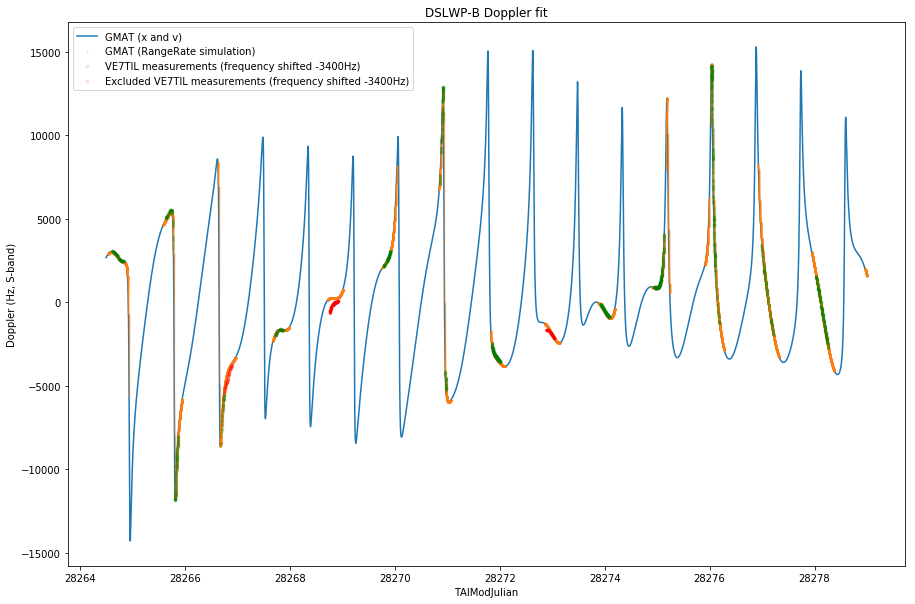

In [10]:
plt.figure(figsize = [15,10])
plt.plot(report[:, tai], -dslwp_rangerate*1e3*freq/c)
plt.plot(gmat_doppler[:,0], -0.5*gmat_doppler[:,1]*1e3*freq/c, '.', markersize=1, alpha=0.5)
plt.plot(doppler[~exclude,0], doppler[~exclude,1]-freq+f_shift,'.', alpha=0.1, markersize=5, color='green')
plt.plot(doppler[exclude,0], doppler[exclude,1]-freq+f_shift,'.', alpha=0.1, markersize=5, color='red')
plt.title('DSLWP-B Doppler fit')
plt.xlabel('TAIModJulian')
plt.ylabel('Doppler (Hz, S-band)')
plt.legend(['GMAT (x and v)', 'GMAT (RangeRate simulation)', 'VE7TIL measurements (frequency shifted {}Hz)'.format(f_shift), 'Excluded VE7TIL measurements (frequency shifted {}Hz)'.format(f_shift)]);